In [1]:
# This version uses both CNN layers and dropout in an effort to increase accuracy
# it also includes spatial dropout after the CNN layer
# and the entire model is visualized at the bottom

# Here I will be building out the architecture of the first classification LSTM
# At each time step, this LSTM will take in a vector representing the extracted audio and visual features from Liris-ACCEDE
# Its goal is to output whether or not the movie induces fear at each time step


# First, import necessary libraries
import tensorflow as tf
import numpy as np

/Users/chloeloughridge/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
# setting up the keras stuff
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, SpatialDropout1D
from keras.layers import LSTM, Conv1D
# my custom data_utils file
from data_utils_local08 import *

Using TensorFlow backend.


In [3]:
# for plotting the model
# !pip install pydot
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [4]:
# uploading the X values
X_input = load_Xinput(get_fc6_directory(7))
print(X_input.shape)

(212, 4096)


In [5]:
# uploading the Y values
y_data_input = fear_oneHot(212, 'fear_annotations_part01/MEDIAEVAL18_7_Fear.txt')
print(y_data_input.shape)

(212,)


In [6]:
# Uploading part01 of the local fc6 data

timesteps = 212   # the number of seconds in movie 07 --> i will figure out how to programmatically get this value
data_dim = 4096    # the number of output values from VGG16 layer fc6 --> switch to programmatic later
num_movies = 4
batch_size = 7
num_epochs = 5
validation_num = 3

# set up the X_train_data master array
X_train_data = np.zeros([num_movies, timesteps, data_dim]) #oooooh this array will have to be as long as the longest
                                                            # movie and padded with zeros --> this won't cause problems
                                                            # right?
X_valid_data = np.zeros([validation_num, timesteps, data_dim])
        
# for each movie number between and including 7 and 13
for num in range(num_movies):
    # load the X_input data
    X_input = load_Xinput(get_fc6_directory(7 + num))
    # put this X_input data into the X_train_data array
    X_train_data[num, :, :] = X_input
print(X_train_data.shape)



(4, 212, 4096)


In [7]:
# loading X validation set
X_valid_data = np.zeros([validation_num, timesteps, data_dim])

for num in range(validation_num):
    # load the X_input data
    X_valid = load_Xinput(get_fc6_directory(7 + num_movies + num))
    # put this X_input data into the X_train_data array
    X_valid_data[num, :, :] = X_valid
print(X_valid_data.shape)


(3, 212, 4096)


In [8]:
# uploading the y data

# set up y_train_data master array
Y_train_data = np.zeros([num_movies, timesteps])

# for each movie number between and including 7 and 13
for num in range(num_movies):
    # create the appropriate path to the fear annotation data
    #print(num)
    path = os.path.join('fear_annotations_part01/MEDIAEVAL18_{}_Fear.txt'.format(7+num))
    # create a one-hot vector
    y_data = fear_oneHot(timesteps, path)
    # add this one-hot vector to y_train_data
    Y_train_data[num, :] = y_data
print(Y_train_data[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
# upload the Y validation set
Y_valid_data = np.zeros([validation_num, timesteps])

# for each movie number in validation set
for num in range(validation_num):
    # create the appropriate path to the fear annotation data
    #print(num)
    path = os.path.join('fear_annotations_part01/MEDIAEVAL18_{}_Fear.txt'.format(7+ num_movies + num))
    # create a one-hot vector
    y_valid = fear_oneHot(timesteps, path)
    # add this one-hot vector to y_train_data
    Y_valid_data[num, :] = y_valid
print(Y_valid_data[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
# constructing a many-to-one LSTM model in keras --> inspiration: https://stackoverflow.com/questions/43034960/many-to-one-and-many-to-many-lstm-examples-in-keras
# i will start by training a model on only the VGG16 fc6 layer output (that's just one feature)
# should I eventually abstract this LSTM model? Create its own object file?
model = Sequential()

# add a convolutional layer over here
model.add(Conv1D(10, kernel_size=3, activation="sigmoid", input_shape=(timesteps, data_dim)))

# just for fun
model.add(SpatialDropout1D(0.25))

# first LSTM layer
model.add(LSTM(212, return_sequences=True))

# dropout layer
model.add(Dropout(0.5))

# another LSTM layer
model.add(LSTM(212, return_sequences=True))

# going to try adding a flatten layer in here
model.add(Flatten()) # I got this from a github thing, but I still don't completely understand why it works

# add the final dense layer and then softmax
model.add(Dense(212, activation='softmax'))
# going to add a softmax activation to this
#model.add(Activation('softmax'))

In [11]:
# compiling LSTM model
# note that Ng used an Adam optimizer and categorical cross-entropy loss
# but this is a binary classification problem so I think the parameters below should suffice
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['binary_accuracy'])

In [23]:
# running the LSTM model
model.fit(X_train_data, Y_train_data, epochs = 20, validation_data=(X_valid_data, Y_valid_data))
print("finished training!")

Train on 4 samples, validate on 3 samples
Epoch 1/20
4/4 [==============================] - 3s 763ms/step - loss: 1.0442 - binary_accuracy: 0.8054 - val_loss: 2.9644 - val_binary_accuracy: 0.7689
Epoch 2/20
4/4 [==============================] - 1s 204ms/step - loss: 1.3931 - binary_accuracy: 0.8054 - val_loss: 2.2501 - val_binary_accuracy: 0.7689
Epoch 3/20
4/4 [==============================] - 1s 251ms/step - loss: 1.8022 - binary_accuracy: 0.8054 - val_loss: 2.0268 - val_binary_accuracy: 0.7689
Epoch 4/20
4/4 [==============================] - 1s 294ms/step - loss: 1.5170 - binary_accuracy: 0.8054 - val_loss: 1.9313 - val_binary_accuracy: 0.7689
Epoch 5/20
4/4 [==============================] - 1s 276ms/step - loss: 1.3067 - binary_accuracy: 0.8054 - val_loss: 1.2506 - val_binary_accuracy: 0.7689
Epoch 6/20
4/4 [==============================] - 1s 271ms/step - loss: 1.0844 - binary_accuracy: 0.8054 - val_loss: 1.6712 - val_binary_accuracy: 0.7689
Epoch 7/20
4/4 [==================

In [26]:
# trying to view the model output
out = model.predict(X_train_data)
print("model prediction:")
print(out[0])
print("target:")
print(Y_train_data[0])

print("before 64:")
print(out[0][63])
print("64:")
print(out[0][65])

print("rounded")
print(np.round(out)[0])

model prediction:
[1.5196355e-07 3.9365766e-08 1.1666211e-08 2.9819137e-08 1.1119864e-07
 2.5930452e-08 3.4395995e-08 9.4654418e-09 6.4271333e-08 9.0170644e-09
 2.6179277e-08 2.1710793e-08 5.3078217e-08 8.9951104e-09 8.2388061e-09
 1.5145423e-08 4.4607084e-08 2.6558396e-07 2.3572177e-07 2.8888974e-07
 7.0404158e-06 3.7715604e-06 4.2565114e-07 4.3033810e-07 3.0542708e-07
 8.1208827e-06 9.7397096e-06 1.8496506e-06 4.9017668e-05 3.4772820e-05
 2.8764445e-05 2.4046751e-05 9.5762472e-05 1.7088316e-05 5.4705069e-05
 3.5920857e-05 6.1904109e-07 8.6675769e-05 8.4074010e-05 1.1712875e-06
 9.4848349e-07 7.0600770e-08 7.8952624e-08 5.6531437e-08 1.5574985e-07
 4.7688481e-08 9.9840307e-08 4.6553765e-08 1.2508207e-07 5.0673677e-08
 8.6592008e-06 6.0885242e-08 4.1828447e-05 1.0177346e-04 5.6338518e-05
 1.7602665e-04 1.0976451e-04 6.3210391e-05 4.8141286e-05 7.8665085e-05
 1.4424013e-07 1.2598485e-07 6.2352754e-08 2.9701752e-08 9.9999297e-01
 9.9998963e-01 9.9998355e-01 9.9997711e-01 9.9999118e-01 9.

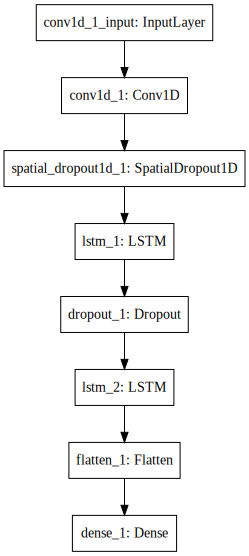

In [12]:
#try visualizing this model at some point?
SVG(model_to_dot(model).create(prog='dot', format="svg"))